In [31]:
import pandas as pd
train = pd.read_csv("walmart-sales-forecast/train.csv")
test = pd.read_csv("walmart-sales-forecast/test.csv")
features = pd.read_csv("walmart-sales-forecast/features.csv")
stores = pd.read_csv("walmart-sales-forecast/stores.csv")

for df in [train, features, test]:
    df["Date"] = pd.to_datetime(df["Date"])

features.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis =1 , inplace = True )

df = (train.merge(features, on=["Store", "Date", "IsHoliday"], how="left").merge(stores, on="Store", how="left"))
df_test = (test.merge(features, on=["Store", "Date", "IsHoliday"], how="left").merge(stores, on="Store", how="left"))

# convert categorical features such as: IsHoliday into numerical features such true: 1, false: 0
df['IsHoliday'] = df['IsHoliday'].map({True:1, False:0})
df['Type'].value_counts()
df['Type'] = df['Type'].map({'A': 1, 'B': 2, 'C': 3})

df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,1,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,1,151315


In [61]:
def make_time_features(fe):
    d = fe.copy()
    d["Year"] = d["Date"].dt.year
    d["Month"] = d["Date"].dt.month
    d["Week"] = d["Date"].dt.isocalendar().week.astype(int)
    d["Day"] = d["Date"].dt.day
    for L in [1,2,4,8,13,26,52]:
        d[f"lag_{L}"] = d["Weekly_Sales"].shift(L)
    d["roll4"] = d["Weekly_Sales"].shift(1).rolling(4).mean()
    d["roll13"] = d["Weekly_Sales"].shift(1).rolling(13).mean()
    return d.dropna()

df_train = make_time_features(df)
df_test = make_time_features(df_test)

#target = "Weekly_Sales"
#X = df_train.drop(columns=["Date", "Weekly_Sales"])
#y = df_train[target]

# Pick one Store & Dept
store_id, dept_id = 1, 1
data = df_train[(df_train.Store==store_id) & (df_train.Dept==dept_id)].copy()

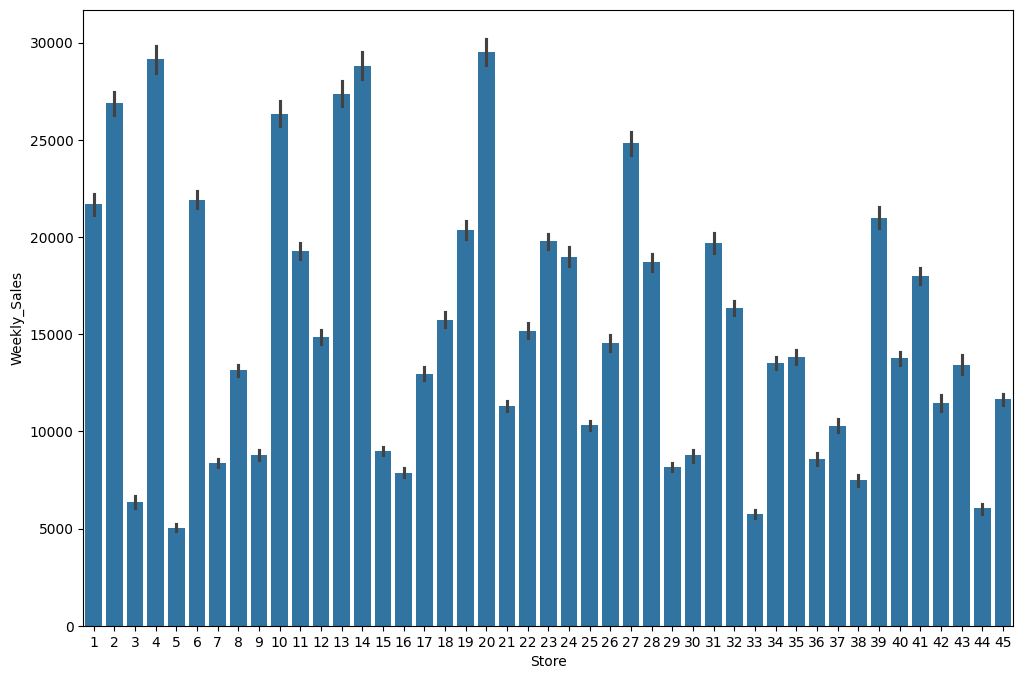

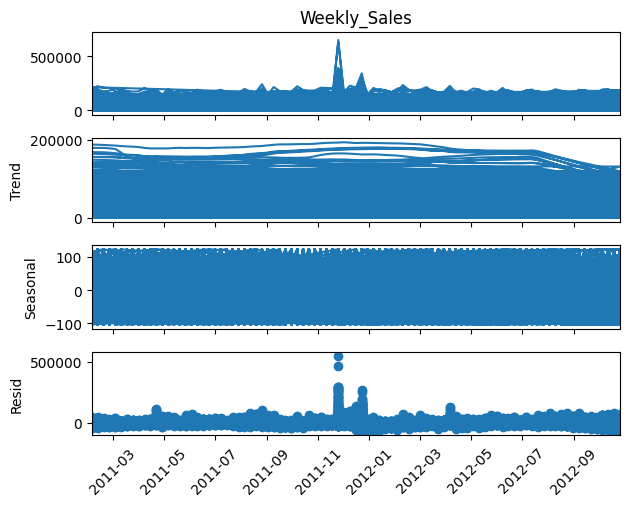

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.barplot(x='Store',y='Weekly_Sales',data=df_train)
plt.show()


# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train.set_index("Date")["Weekly_Sales"], model="additive", period=30)
decomp.plot()
plt.xticks(rotation=45)
plt.show()

In [111]:
train_df, valid_df = data.iloc[:-12], data.iloc[-12:]
features = [c for c in data.columns if c not in ["Date","Weekly_Sales","Store","Dept"]]

X_train, y_train = train_df[features], train_df.Weekly_Sales
X_valid, y_valid = valid_df[features], valid_df.Weekly_Sales

In [113]:
# train linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model_lg = LinearRegression().fit(X_train, y_train)
pred_lg = model_lg.predict(X_valid)
mae_lg = mean_absolute_error(y_valid, pred_lg)
rmse_lg = mean_squared_error(y_valid, pred_lg)
rmse_lg = np.sqrt(mae_lg)

print(f"Linear Regression MAE: {mae_lg:.2f}, RMSE: {rmse_lg:.2f}")

Linear Regression MAE: 1719.61, RMSE: 41.47


In [118]:
# train XGBoost model
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_valid)
mae_xgb = mean_absolute_error(y_valid, pred_xgb)
rmse_xgb = mean_squared_error(y_valid, pred_xgb)
rmse_xgb = np.sqrt(mae_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost MAE: 1216.27, RMSE: 34.88


In [ ]:
# train LightGBM model
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators=800, learning_rate=0.05, max_depth=6, random_state=42)
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_valid)
mae_lgb = mean_absolute_error(y_valid, pred_lgb)
rmse_lgb = mean_squared_error(y_valid, pred_lgb)
rmse_lgb = np.sqrt(mae_lgb)

print(f"LightGBM MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}")

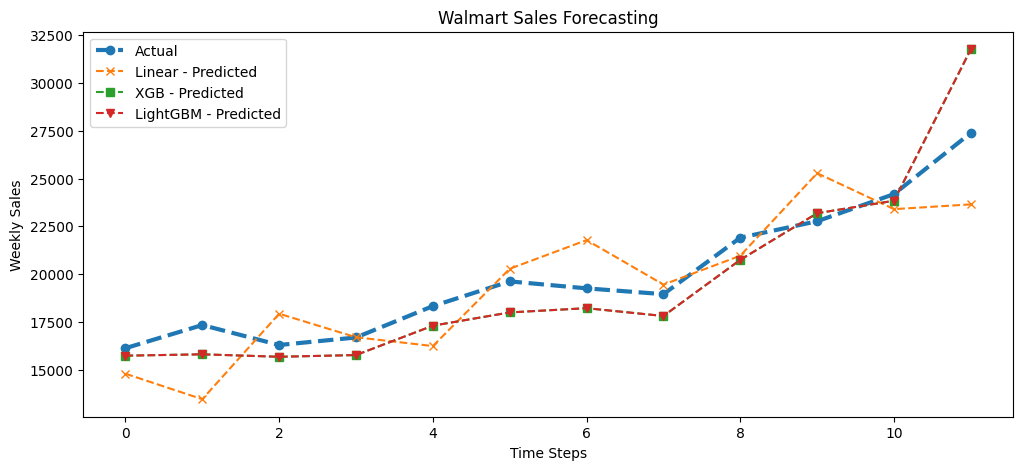

In [120]:
# Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_valid.values[:50], label="Actual", linestyle="--", linewidth=3, marker='o')
plt.plot(pred_lg[:50], label="Linear - Predicted", linestyle="--", marker='x')
plt.plot(pred_xgb[:50], label="XGB - Predicted", linestyle="--", marker='s')
plt.plot(pred_xgb[:50], label="LightGBM - Predicted", linestyle="--", marker='v')
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.title("Walmart Sales Forecasting")
plt.legend()
plt.show()

In [121]:
last = df.iloc[-1].copy()
next_date = last.Date + pd.Timedelta(days=7)

for L in [1,2,4,8,13,26,52]:
    last[f"lag_{L}"] = df.Weekly_Sales.iloc[-L]
last["roll4"] = df.Weekly_Sales.iloc[-4:].mean()
last["roll13"] = df.Weekly_Sales.iloc[-13:].mean()

last["Date"] = next_date
last["Year"] = next_date.year
last["Month"] = next_date.month
last["Week"] = next_date.isocalendar().week
last["Day"] = next_date.day

X_next = last[features].values.reshape(1,-1)
next_pred = xgb.predict(X_next)[0]

print("Forecast for next week:", next_date.date(), "->", round(next_pred,2))

Forecast for next week: 2012-11-02 -> 16826.44
